## Installing Transformers

In [ ]:
!pip install transformers

## Importing torch & pandas

In [ ]:
import torch

In [ ]:
import pandas as pd

## Dataset

In [ ]:
data = pd.read_csv('/content/dataset_3.csv')
data.head()

,tweet,label
0,😞😞,0
1,بالتوفيق ان شاء الله,1
2,الحمدلله على كل حال,1
3,شكرا لك,1
4,ههههههههه,1


In [ ]:
data.replace(to_replace=['pos', 'neg'], value=[1, 0], inplace=True)
data.head()

,tweet,label
0,😞😞,0
1,بالتوفيق ان شاء الله,1
2,الحمدلله على كل حال,1
3,شكرا لك,1
4,ههههههههه,1


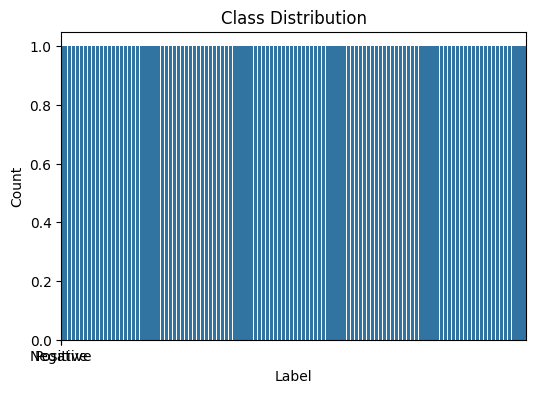

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of labels
plt.figure(figsize=(6,4))
sns.countplot(data['label'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

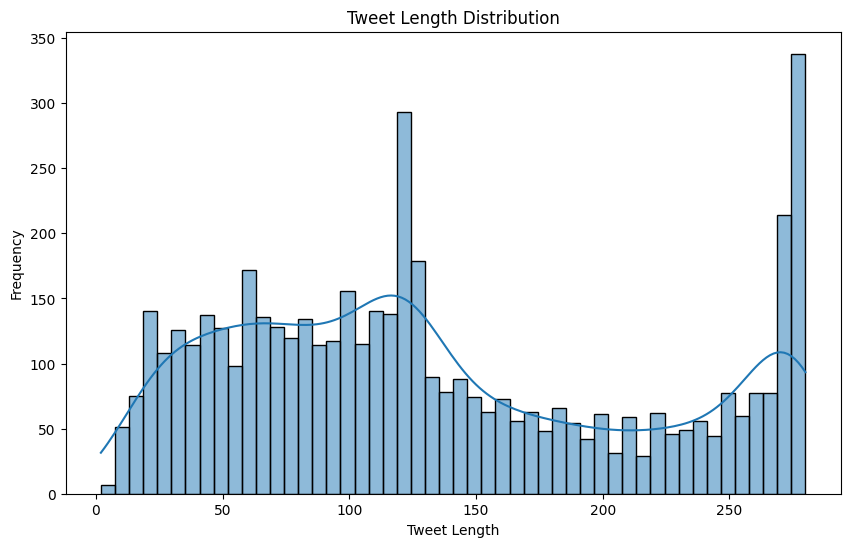

In [ ]:
# useful for tokenization and padding decisions
# Calculate tweet lengths
tweet_lengths = data['tweet'].apply(lambda x: len(x))

# Plot the distribution of tweet lengths
plt.figure(figsize=(10,6))
sns.histplot(tweet_lengths, bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

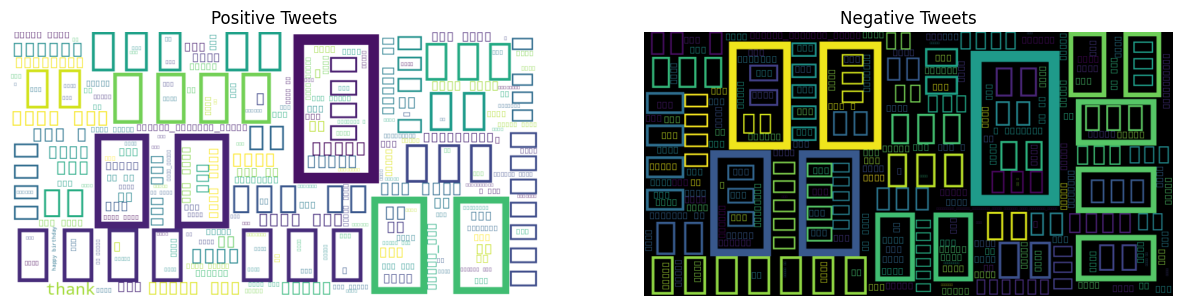

In [ ]:
# insight into the most common words in positive and negative tweets
from wordcloud import WordCloud

# Separate positive and negative tweets
positive_tweets = ' '.join(data[data['label'] == 1]['tweet'])
negative_tweets = ' '.join(data[data['label'] == 0]['tweet'])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_tweets)

# Plot word clouds
plt.figure(figsize=(15,8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Tweets')
plt.axis('off')

plt.show()

## Preprocessing and training the Model

In [ ]:
from sklearn.model_selection import train_test_split
X = data['tweet'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('SI2M-Lab/DarijaBERT', do_lower_case=True)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    return torch.tensor(input_ids), torch.tensor(attention_masks)

In [ ]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X]

# Find the maximum length
MAX_LEN = max([len(sent) for sent in encoded_tweets])
print('Max length: ', MAX_LEN)

Max length:  106


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids, attention_mask = preprocessing_for_bert([X[0]], tokenizer, MAX_LEN)
token_ids = token_ids.squeeze().numpy()
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, tokenizer, MAX_LEN)
val_inputs, val_masks = preprocessing_for_bert(X_test, tokenizer, MAX_LEN)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  😞😞
Token IDs:  [   2  879 1429    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
import torch.nn as nn
from transformers import BertModel
import numpy as np

In [ ]:
# Define the model class with LSTM
class BertLSTMClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('SI2M-Lab/DarijaBERT')
        self.lstm = nn.LSTM(768, 128, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(256, 1)
        self.layer_norm = nn.LayerNorm(256)
        self.classifier = nn.Sequential(
            nn.Linear(256, 50),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(50, 2)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        lstm_output, _ = self.lstm(last_hidden_state)
        attn_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = torch.sum(attn_weights * lstm_output, dim=1)
        context_vector = self.layer_norm(context_vector)
        logits = self.classifier(context_vector)
        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    model = BertLSTMClassifier(freeze_bert=False)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return model, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Define the train function
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    loss_fn = nn.CrossEntropyLoss()
    print("Start training...\n")
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
        if evaluation:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    print("Training complete!")

def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

In [ ]:
# Training and evaluation functions remain the same as previously defined

set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.347587   |     -      |     -     |   32.00  
   1    |   40    |   0.214013   |     -      |     -     |   30.41  
   1    |   60    |   0.209971   |     -      |     -     |   30.03  
   1    |   80    |   0.218871   |     -      |     -     |   30.29  
   1    |   100   |   0.298299   |     -      |     -     |   30.19  
   1    |   120   |   0.306734   |     -      |     -     |   30.07  
   1    |   140   |   0.164945   |     -      |     -     |   30.11  
   1    |   160   |   0.205995   |     -      |     -     |   30.18  
   1    |   180   |   0.260940   |     -      |     -     |   30.13  
   1    |   200   |   0.237962   |     -      |     -     |   30.12  
   1    |   220   |   0.253783   |     -      |     -     |   30.08  
   1    |   240   |   0.229755   |     -      |     -     |   30.02  


## Predicting & Evaluating the model

In [ ]:
import torch.nn.functional as F

# Define the bert_predict function
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities on the test set."""
    model.eval()
    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate all logits and apply softmax to get probabilities
    all_logits = torch.cat(all_logits, dim=0)
    probs = torch.nn.functional.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Accuracy, ROC, AUC

AUC: 0.9760
Accuracy: 95.40%


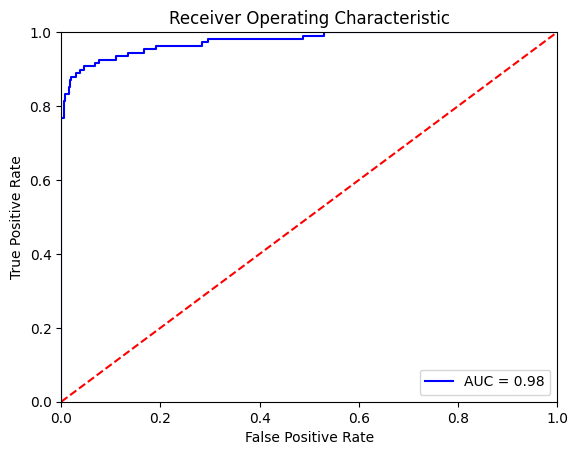

In [ ]:
import matplotlib.pyplot as plt

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

### Do Some Predictions

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(['يبقى غير ذي مصداقية ، ومن يغض الطرف عن الفاسدين ، متواطئ', 'خاصنا نديرو شي اضراب عليهم', 'تفو على حالة كي دايرا'], tokenizer, MAX_LEN)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(['يبقى غير ذي مصداقية ، ومن يغض الطرف عن الفاسدين ، متواطئ',
                                                   'خاصنا نديرو شي اضراب عليهم',
                                                   'تفو على حالة كي دايرا'], tokenizer, MAX_LEN)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Convert predicted probabilities to predicted class labels
pred_labels = np.argmax(probs, axis=1)

# Map class indices to their respective labels (assuming 0 represents negative class and 1 represents positive class)
class_labels = ['negative', 'positive']
pred_class_labels = [class_labels[idx] for idx in pred_labels]

# Print the original sentences along with their predicted class labels
print("Predicted Class Labels:")
for sentence, pred_label in zip(['يبقى غير ذي مصداقية ، ومن يغض الطرف عن الفاسدين ، متواطئ',
                                 '😢💔😞',
                                 'اليوم كان أسوء نهار فحياتي 😔💔'], pred_class_labels):
    print(f"Sentence: {sentence} --> Predicted Class: {pred_label}")


Tokenizing data...
Predicted Class Labels:
Sentence: يبقى غير ذي مصداقية ، ومن يغض الطرف عن الفاسدين ، متواطئ --> Predicted Class: negative
Sentence: 😢💔😞 --> Predicted Class: negative
Sentence: اليوم كان أسوء نهار فحياتي 😔💔 --> Predicted Class: negative


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted positive: ", preds.sum())

Number of tweets predicted positive:  0
